### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [2]:
# Kludge to fix the bug with draw_ellipse in astroML
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [2]:
#importing packages
import numpy as np
import matplotlib.pyplot as plt
import scipy

### Part 1:

In [3]:
#Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. 
# Make a $2$-D scatter plot of the data colored by their labels. 

#Reading in the dataset:
data = np.load('/home/nowickr/astr_8070_s24/coursework/homeworks/hw_data/hw6_data_1.npy')

#reading size of dataset
print('Shape of Dataset:',data.shape)

Shape of Dataset: (1000, 3)


Text(0.5, 1.0, 'HW6 Dataset')

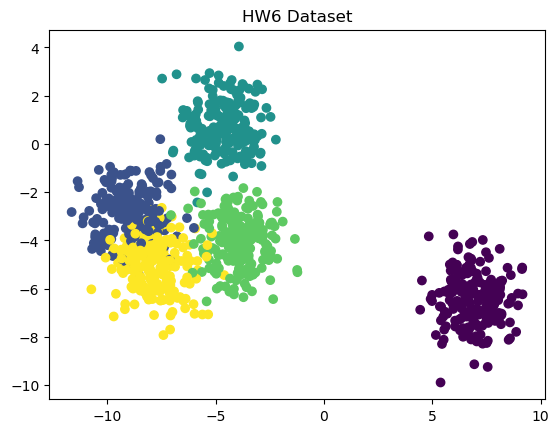

In [4]:
#setting variables
x = data[:,0]
y = data[:,1]
labels = data[:,2]

#making scatterplot
plt.scatter(x, y, c=labels) #c helps us set colors
plt.title('HW6 Dataset')

### Part 2

In [5]:
#Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth,
# testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel 
# density estimate of the distribution. 
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#choosing 30 bandwidths between 0.1 and 1.0
bandwidths = np.linspace(0.1,1.0,30)

In [8]:
#concatenating x and y data
concat = np.concatenate([x,y])

In [26]:
#from lecture 14
K = 5 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, :2]) #Fit the CONCATENATED DATA made in the previous cell
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.4724137931034482


0.4724137931034482


Text(0.5, 1.0, '2D KDE of Data')

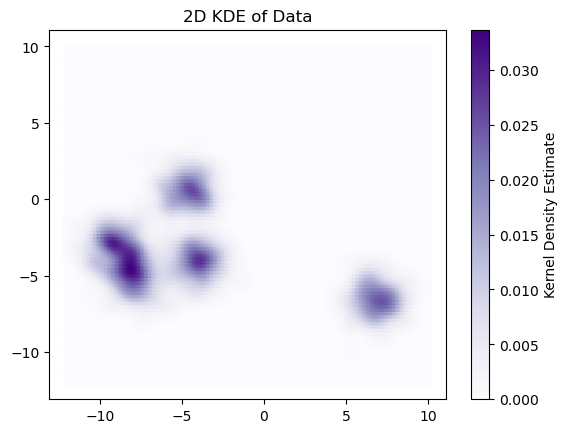

In [34]:
#Again from Lecture 14!

#2D Kernel Density
K = 5 # 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bandwidths}, cv=K) # Try each bandwidth with K-folds
grid.fit(data[:, :2]) #HERE I AM USING OUR 2D DATA SET AS THE DATA TO FIT TO
h_opt = grid.best_params_['bandwidth']
print(h_opt)
#back to regularly scheduled instantiation of KDE
kde = KernelDensity(kernel='gaussian', bandwidth=h_opt) #using optimal bandwidth h_opt
kde.fit(data[:,:2]) #fit the model to the data

u = v = np.linspace(-12,10,100) #defining a linspace to plot over; this should extend across the full range of the data
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T
dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid

plt.scatter(Xgrid[:,0], Xgrid[:,1], c=dens, 
            cmap="Purples", edgecolor="None")
plt.colorbar(label='Kernel Density Estimate')
plt.title('2D KDE of Data')

### Part 3

In [32]:
#Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. 
#Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?
from astroML.density_estimation import KNeighborsDensity
from astropy.visualization import hist
from sklearn.neighbors import KernelDensity

ValueError: x and y must have same first dimension, but have shapes (100,) and (10000,)

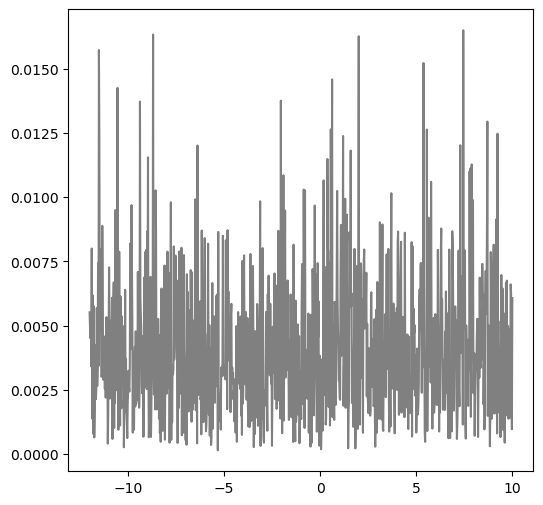

In [73]:
#FROM LECTURE 14:
 
#plot the results
fig = plt.figure(figsize=(6, 6))
N = 5000 #dimensions of distribution(?)
k = 20 #Number of neighbors

#xN = x[:N]
t = np.linspace(-12, 10, 1000)

# Compute density with KDE
kde = KernelDensity(bandwidth=h_opt, kernel='gaussian')
kde.fit(data[:, :1])
dens_kde = np.exp(kde.score_samples(t[:].reshape(-1,1)))

# Compute density with Bayesian nearest neighbors
nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
nbrs.fit(data[:, :2])
dens_nbrs = nbrs.eval(data[:, :2]) / N


# plot the results
#plt.plot(t, true_pdf(t), ':', color='black', 
         #zorder=3, label="Generating Distribution")
#plt.plot(xN, -0.005 * np.ones(len(xN)), '|k')
plt.plot(t, dens_nbrs, '-', lw=1.5, color='gray', 
         zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.plot(u, dens, '-', color='black', 
         zorder=3, label="Kernel Density (h=0.1)")

# label the plot
plt.ylabel('$p(x)$')
plt.legend(loc='upper right')
#plt.xlim(0, 20)
#plt.ylim(-0.01, 0.4001)

plt.show()

### Part 4

In [ ]:
#Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. 
#Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? 
#Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, 
# and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*